<a href="https://colab.research.google.com/github/mingshey/python_mechanics/blob/main/Motion_of_a_Spinning_Top.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 회전하는 팽이
* 참조: Fowles 'Analytical Mechanics' 9.7 Motion of a Top

In [ ]:
import numpy as np
import sympy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches # For custom legend
import matplotlib.lines as mlines # For line objects in legend
import mpl_toolkits.mplot3d.art3d as art3d # For Poly3DCollection

In [ ]:
# --- 1. 심볼 및 변수 정의 ---
t = sp.Symbol('t')
g, m, h, I1, I3 = sp.symbols('g m h I1 I3')
theta = sp.Function('theta')(t)
phi = sp.Function('phi')(t)
psi = sp.Function('psi')(t)

# 1차 미분 (각속도)
theta_dot = sp.diff(theta, t)
phi_dot = sp.diff(phi, t)
psi_dot = sp.diff(psi, t)

# 2차 미분 (각가속도)
theta_ddot = sp.diff(theta, t, 2)
phi_ddot = sp.diff(phi, t, 2)
psi_ddot = sp.diff(psi, t, 2)

In [ ]:
# --- 2. 초기 조건 및 시스템 파라미터 설정 ---
print("--- 2. 초기 조건 및 시스템 파라미터 설정 시작 ---")

# 팽이의 시각화를 위한 추가 파라미터
disk_radius = 0.5    # 원반의 반지름 [m]
disk_thickness = 0.02 # 원반의 두께 [m]
rod_length = 0.5    # 중심 막대의 길이 (원반 중심에서 위로 뻗어나가는 길이) [m]
rod_radius = 0.01    # 중심 막대의 반지름 [m]

# 시스템 파라미터 (예시 값)
m_val = 0.1   # 팽이의 질량 [kg]
I3_val = (1/2) * m_val * (disk_radius**2)  # 대칭축에 대한 관성 모멘트 [kg*m^2]
I1_val = I3_val / 2  # 대칭축에 수직한 관성 모멘트 [kg*m^2]
g_val = 9.81  # 중력 가속도 [m/s^2]
h_val = 0.5   # 고정점에서 질량 중심까지의 거리 (팽이의 질량 중심이 원점에서 h만큼 위로 떨어져 있다고 가정) [m]

--- 2. 초기 조건 및 시스템 파라미터 설정 시작 ---


In [ ]:
# --- 3. 운동 에너지 (T)와 위치 에너지 (U) 계산 ---
# 오일러 각을 이용한 회전 운동 에너지
# T = 1/2 * I_1 * (theta_dot^2 + phi_dot^2 * sin(theta)^2) + 1/2 * I_3 * (phi_dot * cos(theta) + psi_dot)^2
T = 0.5 * I1 * (theta_dot**2 + (phi_dot * sp.sin(theta))**2) + \
    0.5 * I3 * (phi_dot * sp.cos(theta) + psi_dot)**2

# 위치 에너지
# U = m * g * h * cos(theta)
U = m * g * h * sp.cos(theta)

# --- 4. 라그랑지안 (L) 구성 ---
L = T - U

# --- 5. 오일러-라그랑주 방정식 유도 ---
# theta에 대한 오일러-라그랑주 방정식
EL_theta = sp.diff(sp.diff(L, theta_dot), t) - sp.diff(L, theta)

# phi에 대한 오일러-라그랑주 방정식
EL_phi = sp.diff(sp.diff(L, phi_dot), t) - sp.diff(L, phi)

# psi에 대한 오일러-라그랑주 방정식
EL_psi = sp.diff(sp.diff(L, psi_dot), t) - sp.diff(L, psi)

In [ ]:
# 방정식 단순화 (sp.simplify는 시간이 오래 걸릴 수 있으므로 주의)
EL_theta = sp.simplify(EL_theta)
EL_phi = sp.simplify(EL_phi)
EL_psi = sp.simplify(EL_psi)

# --- 6. 가속도에 대한 연립 방정식 풀이 ---
# 연립 방정식을 풀어 theta_ddot, phi_ddot, psi_ddot에 대한 표현식 찾기
solutions = sp.solve([EL_theta, EL_phi, EL_psi], (theta_ddot, phi_ddot, psi_ddot))

# sympy 표현식으로 결과 추출
theta_ddot_expr = solutions[theta_ddot]
phi_ddot_expr = solutions[phi_ddot]
psi_ddot_expr = solutions[psi_ddot]

# 물리 상수 값 설정
PARAMS = {
    m: m_val,     # 질량
    g: g_val,     # 중력 가속도
    h: h_val,     # 질량 중심까지의 거리
    I1: I1_val,   # X, Y축에 대한 관성 모멘트
    I3: I3_val    # Z축에 대한 관성 모멘트
}

# 파이썬 함수로 변환하기
# `sympy.lambdify`를 사용하여 numpy에서 사용할 수 있는 함수로 변환
# 변수 순서는 [theta, phi, psi, theta_dot, phi_dot, psi_dot] 순서로 맞춤

var_list = [theta, phi, psi, theta_dot, phi_dot, psi_dot]
theta_ddot_func = sp.lambdify(var_list, theta_ddot_expr.subs(PARAMS), 'numpy')
phi_ddot_func = sp.lambdify(var_list, phi_ddot_expr.subs(PARAMS), 'numpy')
psi_ddot_func = sp.lambdify(var_list, psi_ddot_expr.subs(PARAMS), 'numpy')

In [ ]:
# --- 7. 수치 적분 ---

theta0_deg = 20    # deg
psi_dot0 = 360 * 3 # deg/s

def diff_eq_system(y, t):
    """ODE 시스템: y' = f(y, t)"""
    # y = [theta, phi, psi, theta_dot, phi_dot, psi_dot]
    theta, phi, psi, theta_dot, phi_dot, psi_dot = y

    # 위에서 정의한 가속도 함수를 호출
    dydt = [
        theta_dot,
        phi_dot,
        psi_dot,
        theta_ddot_func(theta, phi, psi, theta_dot, phi_dot, psi_dot),
        phi_ddot_func(theta, phi, psi, theta_dot, phi_dot, psi_dot),
        psi_ddot_func(theta, phi, psi, theta_dot, phi_dot, psi_dot)
    ]
    return dydt

# 초기 조건 설정
# y0 = [theta, phi, psi, theta_dot, phi_dot, psi_dot]
y0 = [np.deg2rad(theta0_deg), 0, 0, 0, 0, np.deg2rad(psi_dot0)]  # 예시: theta=30도, phi_dot=20, psi_dot=50

# 시간 배열
time = np.linspace(0, 10, 1000)

# ODE 시스템 풀기
solution = odeint(diff_eq_system, y0, time)

theta_sol = solution[:, 0]
phi_sol = solution[:, 1]
psi_sol = solution[:, 2]
theta_dot_sol = solution[:, 3]
phi_dot_sol = solution[:, 4]
psi_dot_sol = solution[:, 5]

In [ ]:
time.shape

(1000,)

--- 5. 결과 시각화 시작 ---


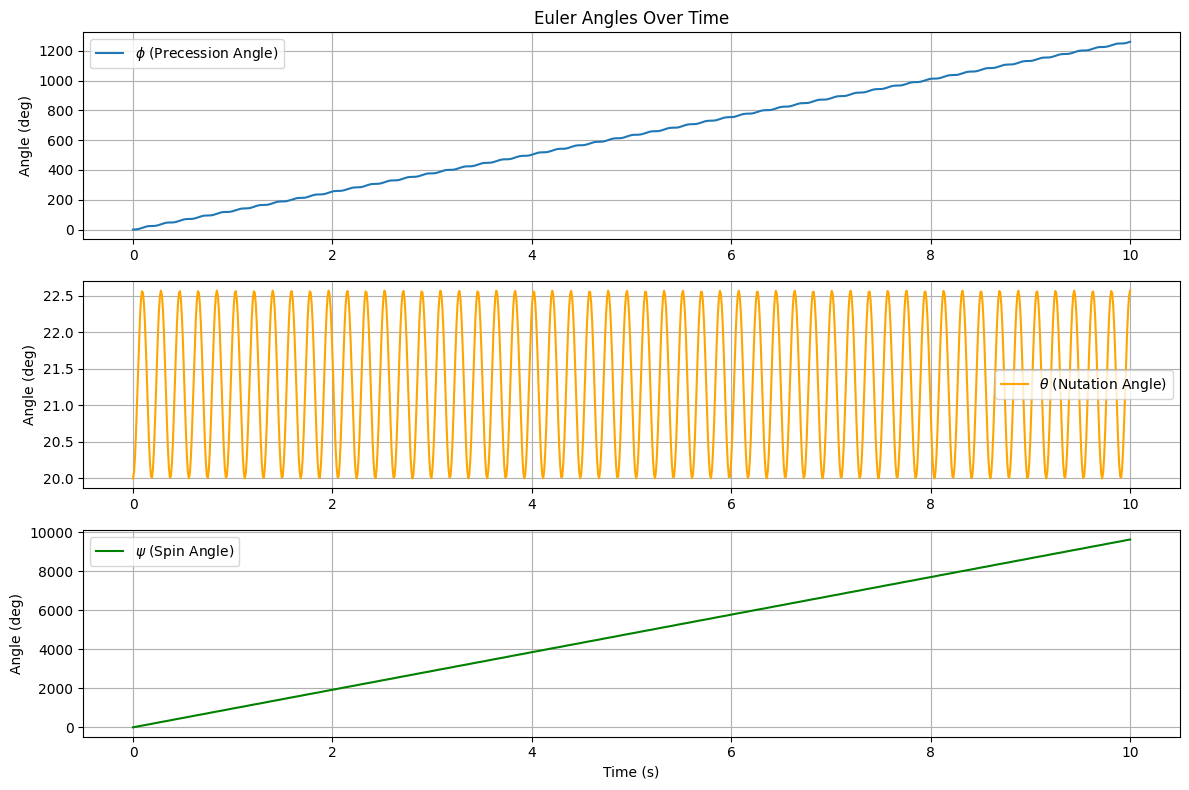

In [ ]:
# --- 8. 결과 시각화 ---
print("--- 5. 결과 시각화 시작 ---")

# 오일러 각의 시간 변화 플롯 (이전과 동일)
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, np.rad2deg(phi_sol), label=r'$\phi$ (Precession Angle)') # r''로 수정
plt.ylabel('Angle (deg)')
plt.title('Euler Angles Over Time')
plt.grid(True)
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(time, np.rad2deg(theta_sol), label=r'$\theta$ (Nutation Angle)', color='orange') # r''로 수정
plt.ylabel('Angle (deg)')
plt.grid(True)
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(time, np.rad2deg(psi_sol), label=r'$\psi$ (Spin Angle)', color='green') # r''로 수정
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

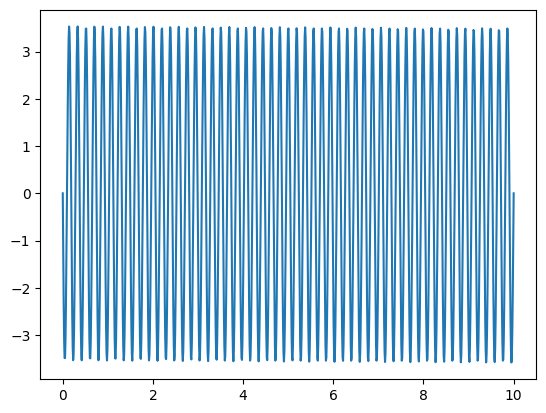

In [ ]:
phi_dot_avg = (phi_sol[-1] - phi_sol[0]) / (time[-1] - time[0])
plt.plot(time, np.rad2deg(phi_sol - time * phi_dot_avg))

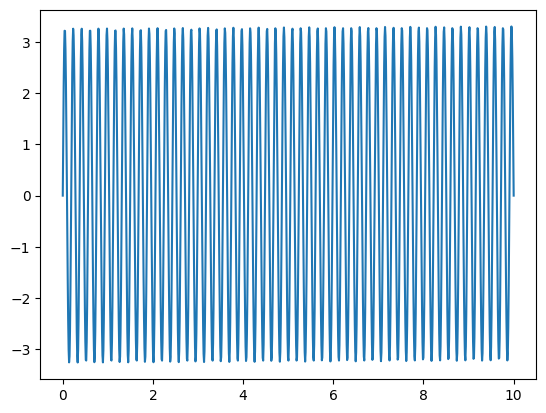

In [ ]:
psi_dot_avg = (psi_sol[-1] - psi_sol[0]) / (time[-1] - time[0])
plt.plot(time, np.rad2deg(psi_sol - time * psi_dot_avg))

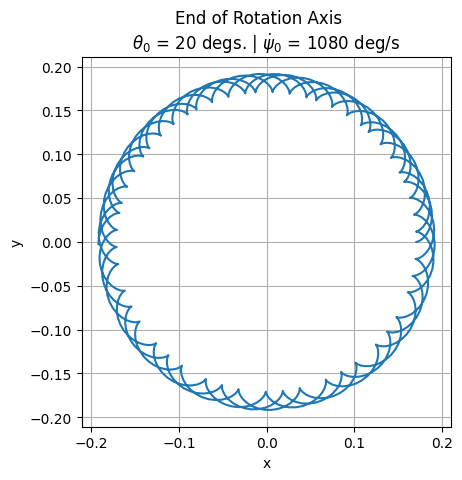

In [ ]:
# 회전축 끝의 x, y 좌표
x_end = h_val * np.sin(theta_sol) * np.cos(phi_sol)
y_end = h_val * np.sin(theta_sol) * np.sin(phi_sol)

plt.axes().set_aspect(1)
plt.grid()
plt.plot(x_end, y_end)
plt.xlabel('x')
plt.ylabel('y')
plt.suptitle('End of Rotation Axis')
plt.title(r'$\theta_0$ = ' + f'{theta0_deg} degs. | ' + r'$\dot{\psi}_0$ = ' + f'{psi_dot0} deg/s')
plt.show()

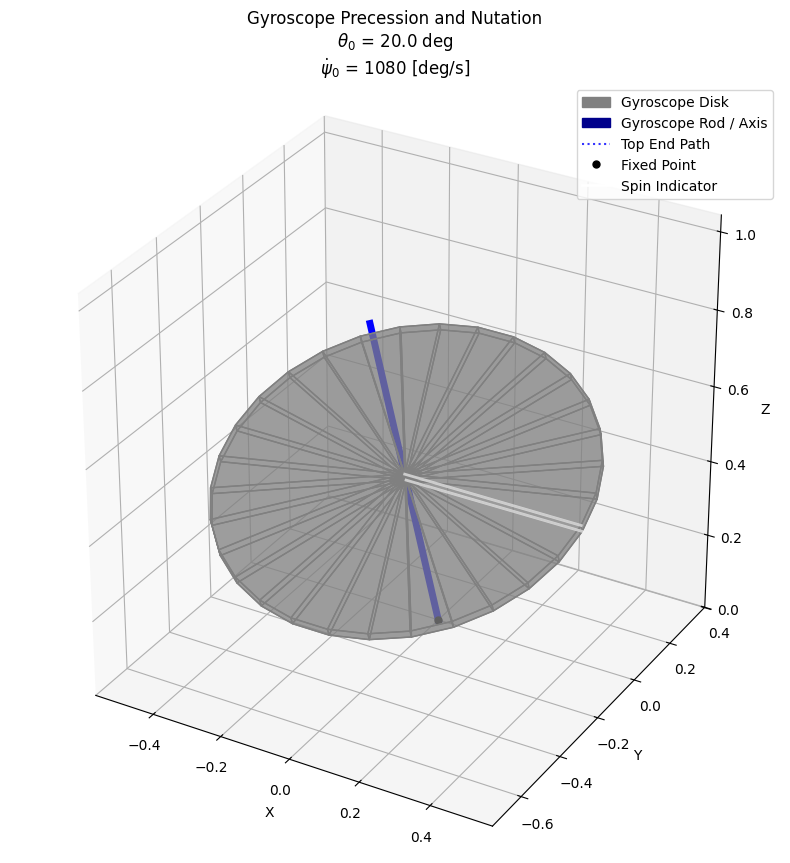

In [ ]:
# 3D 애니메이션 (팽이의 원반 및 막대 시각화)
fig_3d = plt.figure(figsize=(10, 10))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.set_box_aspect((1, 1, 1))

# 3D 축의 aspect ratio를 'equal'하게 설정하는 함수
def set_axes_equal(ax):
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])

    ranges = limits[:, 1] - limits[:, 0]
    max_range = np.max(ranges)

    mid_x = np.mean(limits[0])
    mid_y = np.mean(limits[1])
    mid_z = np.mean(limits[2])

    ax.set_xlim3d([mid_x - max_range / 2, mid_x + max_range / 2])
    ax.set_ylim3d([mid_y - max_range / 2, mid_y + max_range / 2])

    z_min_calculated = mid_z - max_range / 2
    ax.set_zlim3d([max(0, z_min_calculated), mid_z + max_range / 2])


ax_3d.set_xlabel('X')
ax_3d.set_ylabel('Y')
ax_3d.set_zlabel('Z')
theta0_name = r'$\theta_0$'
psi_dot0_name = r'$\dot{\psi}_0$'
ax_3d.set_title(f'Gyroscope Precession and Nutation\n{theta0_name} = {theta0_deg:.1f} deg\n{psi_dot0_name} = {psi_dot0} [deg/s]')
ax_3d.grid(True)

# 회전 행렬 함수 정의 (Z-X'-Z'' 오일러 각)
def rotation_matrix(phi, theta, psi):
    # R_z(phi)
    R_z_phi = np.array([
        [np.cos(phi), -np.sin(phi), 0],
        [np.sin(phi), np.cos(phi), 0],
        [0, 0, 1]
    ])
    # R_x(theta)
    R_x_theta = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    # R_z(psi)
    R_z_psi = np.array([
        [np.cos(psi), -np.sin(psi), 0],
        [np.sin(psi), np.cos(psi), 0],
        [0, 0, 1]
    ])
    return np.dot(np.dot(R_z_phi, R_x_theta), R_z_psi) # Z-X'-Z'' convention


# --- 팽이 모양 정의 (Poly3DCollection을 위한 꼭짓점 및 면) ---
# 원반 윗면/아랫면/옆면을 표현할 vertices 생성
num_segments = 30 # 원반 둘레를 몇 개의 선분으로 나눌지
theta_vals = np.linspace(0, 2 * np.pi, num_segments, endpoint=False) # 0 to 2pi-epsilon

# 원반 윗면 (top_disk_verts): h_val + disk_thickness / 2
top_disk_z = h_val + disk_thickness / 2
top_disk_x = disk_radius * np.cos(theta_vals)
top_disk_y = disk_radius * np.sin(theta_vals)
top_disk_center_body = np.array([0, 0, top_disk_z]) # 중심점
top_disk_pts_body = np.vstack([np.array([top_disk_x, top_disk_y, np.full_like(top_disk_x, top_disk_z)]).T, top_disk_center_body])

top_disk_faces = []
for i in range(num_segments):
    top_disk_faces.append([i, (i + 1) % num_segments, num_segments]) # [현재점, 다음점, 중심점]

# 원반 아랫면 (bottom_disk_verts): h_val - disk_thickness / 2
bottom_disk_z = h_val - disk_thickness / 2
bottom_disk_x = disk_radius * np.cos(theta_vals)
bottom_disk_y = disk_radius * np.sin(theta_vals)
bottom_disk_center_body = np.array([0, 0, bottom_disk_z]) # 중심점
bottom_disk_pts_body = np.vstack([np.array([bottom_disk_x, bottom_disk_y, np.full_like(bottom_disk_x, bottom_disk_z)]).T, bottom_disk_center_body])

bottom_disk_faces = []
for i in range(num_segments):
    # 아랫면은 법선 벡터를 바깥으로 향하게 하기 위해 점의 순서를 반대로 (시계 방향)
    bottom_disk_faces.append([(i + 1) % num_segments, i, num_segments])

# 원반 옆면 (side_cyl_verts)
side_cyl_verts_list = []
for i in range(num_segments):
    p1 = np.array([disk_radius * np.cos(theta_vals[i]), disk_radius * np.sin(theta_vals[i]), bottom_disk_z])
    p2 = np.array([disk_radius * np.cos(theta_vals[i]), disk_radius * np.sin(theta_vals[i]), top_disk_z])
    p3 = np.array([disk_radius * np.cos(theta_vals[(i+1)%num_segments]), disk_radius * np.sin(theta_vals[(i+1)%num_segments]), top_disk_z])
    p4 = np.array([disk_radius * np.cos(theta_vals[(i+1)%num_segments]), disk_radius * np.sin(theta_vals[(i+1)%num_segments]), bottom_disk_z])
    side_cyl_verts_list.append([p1, p2, p3, p4]) # Each face is a rectangle

# 막대 (Rod)
rod_base_body = np.array([0, 0, 0])
rod_top_body_coords = np.array([0, 0, h_val + rod_length]) # 팽이 자체 좌표계에서의 윗부분 끝점

# Spin Indicator (윗면, 아랫면)
spin_indicator_top_z = h_val + disk_thickness / 2
spin_indicator_top_start_body = np.array([0, 0, spin_indicator_top_z])
spin_indicator_top_end_body_relative = np.array([disk_radius, 0, 0]) # 원반 중심에서 뻗어나가는 벡터 (psi=0 기준)

spin_indicator_bottom_z = h_val - disk_thickness / 2
spin_indicator_bottom_start_body = np.array([0, 0, spin_indicator_bottom_z])
spin_indicator_bottom_end_body_relative = np.array([disk_radius, 0, 0]) # 원반 중심에서 뻗어나가는 벡터 (psi=0 기준)

# --- 초기 플로팅 및 핸들 저장 ---
R_initial = rotation_matrix(phi_sol[0], theta_sol[0], psi_sol[0])

# --- 팽이 디스크 그리기 (Poly3DCollection) ---
# 윗면
rotated_top_disk_pts = np.dot(R_initial, top_disk_pts_body.T).T
top_disk_collection = art3d.Poly3DCollection([rotated_top_disk_pts[face] for face in top_disk_faces], color='gray', alpha=0.5)
ax_3d.add_collection3d(top_disk_collection)

# 아랫면
rotated_bottom_disk_pts = np.dot(R_initial, bottom_disk_pts_body.T).T
bottom_disk_collection = art3d.Poly3DCollection([rotated_bottom_disk_pts[face] for face in bottom_disk_faces], color='gray', alpha=0.5)
ax_3d.add_collection3d(bottom_disk_collection)

# 옆면
rotated_side_cyl_verts = []
for face_verts in side_cyl_verts_list:
    rotated_face = np.dot(R_initial, np.array(face_verts).T).T
    rotated_side_cyl_verts.append(rotated_face)
side_cyl_collection = art3d.Poly3DCollection(rotated_side_cyl_verts, color='gray', alpha=0.5)
ax_3d.add_collection3d(side_cyl_collection)

# 팽이의 대칭축 (회전축) - 색깔을 어두운 파란색으로 변경
initial_rod_coords = np.dot(R_initial, np.array([rod_base_body, rod_top_body_coords]).T) # rod_top_body_coords 사용
rod_line, = ax_3d.plot(initial_rod_coords[0], initial_rod_coords[1], initial_rod_coords[2], color='blue', lw=5) # 색상 변경

# 고정점 (원점)
fixed_point_plot, = ax_3d.plot([0], [0], [0], 'ko', markersize=5)

# --- Spin Indicator 초기 생성 ---
# 윗면 스핀 인디케이터
initial_spin_top_start_coords = np.dot(R_initial, spin_indicator_top_start_body)
# psi_i = psi_sol[0] 에 해당하는 바디 프레임 회전
R_psi_body_frame_initial = np.array([
    [np.cos(psi_sol[0]), -np.sin(psi_sol[0]), 0],
    [np.sin(psi_sol[0]), np.cos(psi_sol[0]), 0],
    [0, 0, 1]
])
rotated_vec_to_end_point_top_initial = np.dot(R_psi_body_frame_initial, spin_indicator_top_end_body_relative)
initial_spin_top_end_coords = np.dot(R_initial, (spin_indicator_top_start_body + rotated_vec_to_end_point_top_initial))

spin_indicator_top_line, = ax_3d.plot([initial_spin_top_start_coords[0], initial_spin_top_end_coords[0]],
                                       [initial_spin_top_start_coords[1], initial_spin_top_end_coords[1]],
                                       [initial_spin_top_start_coords[2], initial_spin_top_end_coords[2]],
                                       color='white', lw=2, zorder=10, alpha=0.6) # alpha 추가

# 아랫면 스핀 인디케이터
initial_spin_bottom_start_coords = np.dot(R_initial, spin_indicator_bottom_start_body)
rotated_vec_to_end_point_bottom_initial = np.dot(R_psi_body_frame_initial, spin_indicator_bottom_end_body_relative)
initial_spin_bottom_end_coords = np.dot(R_initial, (spin_indicator_bottom_start_body + rotated_vec_to_end_point_bottom_initial))

spin_indicator_bottom_line, = ax_3d.plot([initial_spin_bottom_start_coords[0], initial_spin_bottom_end_coords[0]],
                                          [initial_spin_bottom_start_coords[1], initial_spin_bottom_end_coords[1]],
                                          [initial_spin_bottom_start_coords[2], initial_spin_bottom_end_coords[2]],
                                          color='white', lw=2, zorder=10, alpha=0.6) # alpha 추가

# 팽이 위쪽 끝의 자취 (Center of Top End Path) - 미리 계산
# 팽이 자체 좌표계의 rod_top_body_coords를 각 시간 단계의 회전 행렬로 변환
all_top_end_path_coords = np.zeros((len(time), 3))
for j in range(len(time)):
    R_j = rotation_matrix(phi_sol[j], theta_sol[j], psi_sol[j])
    # 팽이의 최상단 축 끝점은 (0,0, h_val+rod_length)로 고정되어 있음.
    # 이 점을 외부 좌표계로 변환해야 함.
    all_top_end_path_coords[j] = np.dot(R_j, rod_top_body_coords)

all_top_end_path_x = all_top_end_path_coords[:, 0]
all_top_end_path_y = all_top_end_path_coords[:, 1]
all_top_end_path_z = all_top_end_path_coords[:, 2]

top_end_path_line, = ax_3d.plot([], [], [], 'b:', alpha=0.8, lw=1.5, zorder=100) # zorder 매우 높게 설정

# 모든 플로팅 객체를 그린 후, 초기 축 범위 고정
set_axes_equal(ax_3d)

# Add a custom legend
disk_patch = mpatches.Patch(color='gray', label='Gyroscope Disk')
rod_patch = mpatches.Patch(color='darkblue', label='Gyroscope Rod / Axis') # 범례 색상 변경
top_end_path_patch = mlines.Line2D([], [], color='blue', linestyle=':', alpha=0.8, lw=1.5, label='Top End Path')
fixed_point_patch = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=5, label='Fixed Point')
spin_line_patch = mlines.Line2D([], [], color='white', lw=2, label='Spin Indicator')

ax_3d.legend(handles=[disk_patch, rod_patch, top_end_path_patch, fixed_point_patch, spin_line_patch])


# 애니메이션의 interval 값을 변수로 정의
animation_interval_ms = 20 # 20ms = 50 FPS

# 애니메이션 함수
def animate(i):
    phi_i = phi_sol[i]
    theta_i = theta_sol[i]
    psi_i = psi_sol[i]

    R = rotation_matrix(phi_i, theta_i, psi_i)

    # --- 팽이 객체들의 데이터 업데이트 (Poly3DCollection) ---
    # 윗면
    rotated_top_disk_pts_current = np.dot(R, top_disk_pts_body.T).T
    top_disk_collection.set_verts([rotated_top_disk_pts_current[face] for face in top_disk_faces])

    # 아랫면
    rotated_bottom_disk_pts_current = np.dot(R, bottom_disk_pts_body.T).T
    bottom_disk_collection.set_verts([rotated_bottom_disk_pts_current[face] for face in bottom_disk_faces])

    # 옆면
    current_rotated_side_cyl_verts = []
    for face_verts in side_cyl_verts_list:
        rotated_face = np.dot(R, np.array(face_verts).T).T
        current_rotated_side_cyl_verts.append(rotated_face)
    side_cyl_collection.set_verts(current_rotated_side_cyl_verts)

    # 팽이의 대칭축
    rotated_rod_coords = np.dot(R, np.array([rod_base_body, rod_top_body_coords]).T) # rod_top_body_coords 사용
    rod_line.set_data(rotated_rod_coords[0], rotated_rod_coords[1])
    rod_line.set_3d_properties(rotated_rod_coords[2])

    # --- Spin Indicator 업데이트 ---
    # 바디 프레임 내에서 psi_i만큼 회전하는 행렬
    R_psi_body_frame = np.array([
        [np.cos(psi_i), -np.sin(psi_i), 0],
        [np.sin(psi_i), np.cos(psi_i), 0],
        [0, 0, 1]
    ])

    # 윗면 스핀 인디케이터
    rotated_spin_top_start_coords = np.dot(R, spin_indicator_top_start_body)
    rotated_vec_to_end_point_top = np.dot(R_psi_body_frame, spin_indicator_top_end_body_relative)
    rotated_spin_top_end_coords = np.dot(R, (spin_indicator_top_start_body + rotated_vec_to_end_point_top))

    spin_indicator_top_line.set_data([rotated_spin_top_start_coords[0], rotated_spin_top_end_coords[0]],
                                     [rotated_spin_top_start_coords[1], rotated_spin_top_end_coords[1]])
    spin_indicator_top_line.set_3d_properties([rotated_spin_top_start_coords[2], rotated_spin_top_end_coords[2]])

    # 아랫면 스핀 인디케이터
    rotated_spin_bottom_start_coords = np.dot(R, spin_indicator_bottom_start_body)
    rotated_vec_to_end_point_bottom = np.dot(R_psi_body_frame, spin_indicator_bottom_end_body_relative)
    rotated_spin_bottom_end_coords = np.dot(R, (spin_indicator_bottom_start_body + rotated_vec_to_end_point_bottom))

    spin_indicator_bottom_line.set_data([rotated_spin_bottom_start_coords[0], rotated_spin_bottom_end_coords[0]],
                                         [rotated_spin_bottom_start_coords[1], rotated_spin_bottom_end_coords[1]])
    spin_indicator_bottom_line.set_3d_properties([rotated_spin_bottom_start_coords[2], rotated_spin_bottom_end_coords[2]])

    # 팽이 위쪽 끝의 자취 업데이트 - 매 프레임마다 현재까지의 궤적을 그립니다.
    current_path_x = all_top_end_path_x[:i+1]
    current_path_y = all_top_end_path_y[:i+1]
    current_path_z = all_top_end_path_z[:i+1]

    top_end_path_line.set_data(current_path_x, current_path_y)
    top_end_path_line.set_3d_properties(current_path_z)

    # 반환하는 아티스트 목록 (top_end_path_line을 맨 마지막에 두어 렌더링 순서에 영향)
    return [top_disk_collection, bottom_disk_collection, side_cyl_collection,
            rod_line, fixed_point_plot,
            spin_indicator_top_line, spin_indicator_bottom_line,
            top_end_path_line]

In [ ]:
# 애니메이션 생성 및 표시
ani = animation.FuncAnimation(fig_3d, animate, frames=len(time), interval=animation_interval_ms, blit=False)
plt.show() # 애니메이션을 화면에 보여줌

# --- 애니메이션을 AVI 파일로 저장하는 부분 ---
print("\n--- 애니메이션을 AVI 파일로 저장 시작 ---")

# 저장할 파일 이름
output_filename = f'gyroscope_{theta0_deg}_{psi_dot0}.avi'

# FPS (Frames Per Second) 설정.
fps = 1000 / animation_interval_ms

# MovieWriter 설정 (FFmpeg 사용)
# dpi를 낮춰서 메모리 문제 및 FFmpeg 오류 발생 가능성을 줄입니다.
Writer = animation.writers['ffmpeg']
writer = Writer(fps=fps, metadata=dict(artist='Me'), bitrate=2000) # bitrate 조정 가능

try:
    ani.save(output_filename, writer=writer, dpi=150) # dpi 조정 (200 -> 150으로 감소)
    print(f"애니메이션이 '{output_filename}' (으)로 성공적으로 저장되었습니다.")
except Exception as e:
    print(f"애니메이션 저장 중 오류 발생: {e}")
    print("FFmpeg이 설치되어 있는지 확인하거나, 다른 writer(예: 'pillow' for GIF)를 시도해보세요.")
    print("\nGIF로 저장 시도:")
    try:
        gif_output_filename = 'gyroscope_precession_3d_model_path_fixed.gif'
        # GIF 저장은 dpi와 bitrate에 덜 민감하지만, 파일 크기가 커질 수 있습니다.
        ani.save(gif_output_filename, writer='pillow', fps=fps, dpi=100) # GIF는 일반적으로 낮은 DPI 사용
        print(f"애니메이션이 '{gif_output_filename}' (으)로 성공적으로 저장되었습니다.")
    except Exception as gif_e:
        print(f"GIF 저장 중 오류 발생: {gif_e}")


print(f"\n--- 애니메이션을 {output_filename}로 저장 완료 ---")

print("\n시뮬레이션이 성공적으로 완료되었습니다!")


--- 애니메이션을 AVI 파일로 저장 시작 ---
애니메이션이 'gyroscope_20_1080.avi' (으)로 성공적으로 저장되었습니다.

--- 애니메이션을 gyroscope_20_1080.avi로 저장 완료 ---

시뮬레이션이 성공적으로 완료되었습니다!
